In [64]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from glob import glob
import os

import pandas as pd
from scipy import ndimage, stats
from importlib import reload
from skimage import exposure

import utils

In [2]:
src = '..' + os.sep + 'proc' + os.sep
lsrc = src + 'leyre' + os.sep
msrc = src + 'mather' + os.sep
dst = '..' + os.sep + 'proc' + os.sep

lgenes = os.listdir(lsrc)
mgenes = os.listdir(msrc)
print('Reference:\t', mgenes, '\nGenes to test:\t', lgenes, sep='')

Reference:	['p53']
Genes to test:	['LBD37']


In [3]:
lgidx, mgidx = 0,0
print('Comparing gene', lgenes[lgidx], 'with reference', mgenes[mgidx] )
gdst = dst + lsrc.split(os.sep)[-2] + os.sep + lgenes[lgidx] + os.sep
print('Will save all results in ',gdst)

Comparing gene LBD37 with reference p53
Will save all results in  ../proc/leyre/LBD37/


In [109]:
platenum = 1

ref_file = glob(msrc + mgenes[mgidx] + os.sep + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
plate_file = glob(lsrc + lgenes[lgidx] + os.sep + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
bname = os.path.split(os.path.splitext(plate_file)[0])[1]

print(ref_file, plate_file, bname, sep='\n')

../proc/mather/p53/p53_plate_01_colormatrix.csv
../proc/leyre/LBD37/20231130_plate_01_colormatrix.csv
20231130_plate_01_colormatrix


In [110]:
reference = np.loadtxt(ref_file, delimiter=',')
plate = np.loadtxt(plate_file, delimiter=',')
nrows, ncols = plate.shape
nonzeros = plate != 0

matched = exposure.match_histograms(plate, reference, channel_axis=None)

diff = reference - matched
vlim = np.max( np.abs( [ np.min(diff), np.max(diff) ] ) )

rhist, bins = np.histogram(reference, bins=range(1,257))
phist, _ = np.histogram(plate, bins=bins)
mhist, _ = np.histogram(matched, bins=bins)

imgsize = np.sum(nonzeros)
rcumsum = np.cumsum(rhist)/reference.size
pcumsum = np.cumsum(phist)/imgsize
mcumsum = np.cumsum(mhist)/imgsize

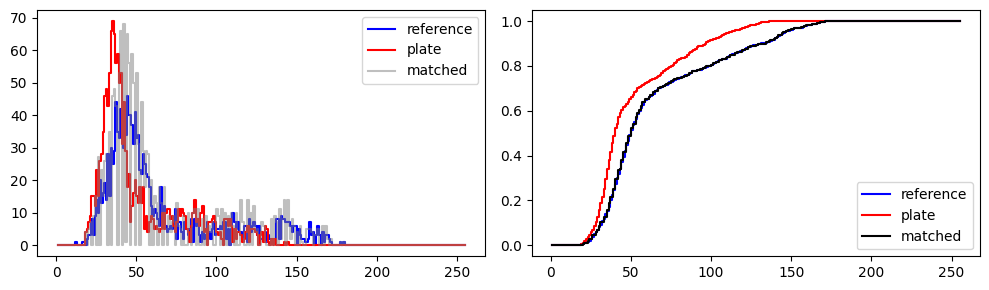

In [111]:
fig, ax = plt.subplots(1,2, figsize=(10,3), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].plot(bins[:-1], rhist, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], phist, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mhist, c='gray', ds='steps', alpha=0.5, label='matched')

i+=1
ax[i].plot(bins[:-1], rcumsum, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], pcumsum, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mcumsum, c='k', ds='steps', label='matched')

for i in range(len(ax)):
    ax[i].legend();

fig.tight_layout()

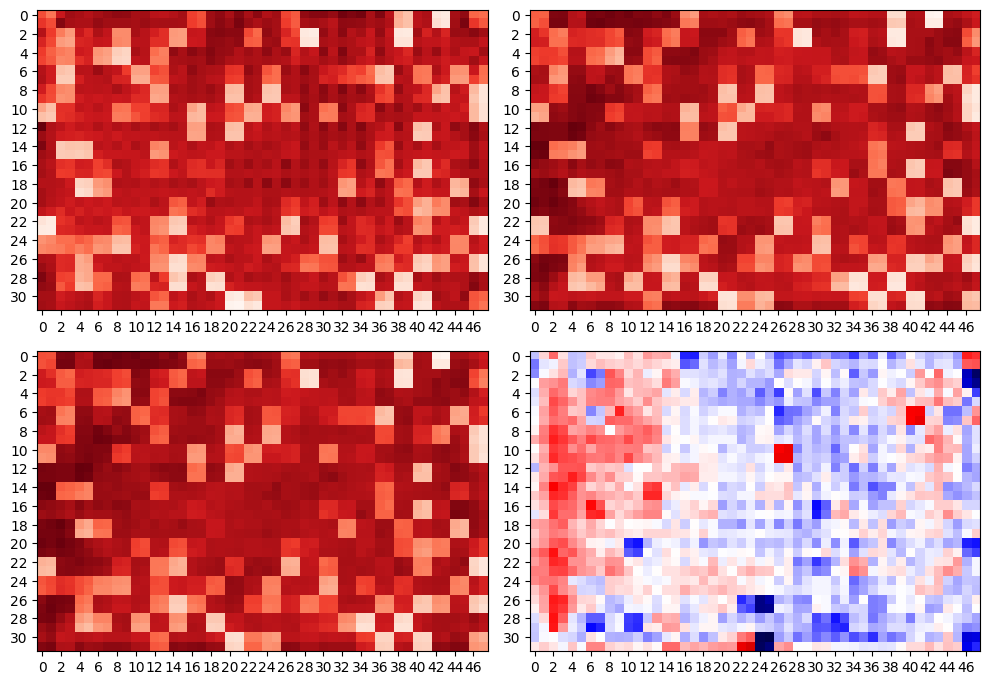

In [112]:
fig, ax = plt.subplots(2,2, figsize=(10,7), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(reference, cmap='Reds_r')
ax[1].imshow(matched, cmap='Reds_r')
ax[2].imshow(plate, cmap='Reds_r')
ax[3].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)

for i in range(len(ax)):
    ax[i].set_xticks(range(0,ncols,2), range(0,ncols,2))
    ax[i].set_yticks(range(0,nrows,2), range(0,nrows,2));
    ax[i].set_aspect('equal')

fig.tight_layout()

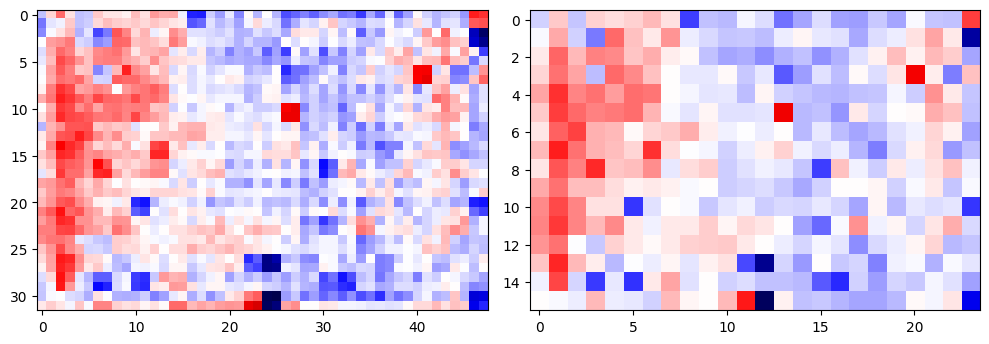

In [113]:
means = np.zeros((nrows//2, ncols//2))
for i in range(0,nrows,2):
    for j in range(0, ncols, 2):
        means[i//2,j//2] = np.mean(diff[i:i+2, j:j+2])

fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[1].imshow(means, cmap='seismic', vmin=-vlim, vmax=vlim)

fig.tight_layout()

In [120]:
dhist, dbins = np.histogram(diff[nonzeros], bins=np.linspace(-vlim-1, vlim+1, 101), density=True)
dcumsum = np.cumsum(dhist)
dcdf = (dcumsum - dcumsum[0])/(dcumsum[-1] - dcumsum[0])
xvals = dbins[:-1].copy()

mhist, _ = np.histogram(means, bins=dbins, density=True)
mcumsum = np.cumsum(mhist)
mcdf = (mcumsum - mcumsum[0])/(mcumsum[-1] - mcumsum[0])

mu, sigma = np.mean(diff), np.std(diff)
normal = 1/(np.std(diff) * np.sqrt(2 * np.pi))*np.exp( - (xvals - np.mean(diff))**2 / (2 * np.std(diff)**2))
ncumsum = np.cumsum(normal)
ncdf = (ncumsum - ncumsum[0])/(ncumsum[-1] - ncumsum[0])

b = np.std(diff)/np.sqrt(2)
laplace = np.exp(-abs(xvals)/b)/(2.*b)

lcdf = np.zeros(len(xvals))
lcdf[xvals < 0] = 0.5*np.exp((xvals[xvals < 0])/b)
lcdf[xvals >= 0] = 1-0.5*np.exp(-(xvals[xvals >= 0])/b)

print(' -- Empirical mean:\t',mu, '\n -- Empirical std:\t', sigma, '\n -- Max difference:\t', vlim, sep='')

alpha = 0.0445
print('\nalpha = {}'.format(alpha), b * np.log(2*alpha), 2*sigma, sep='\t')

alpha = 0.025
print('alpha = {}'.format(alpha), b * np.log(2*alpha), 3*sigma, sep='\t')

 -- Empirical mean:	-0.30539292185745365
 -- Empirical std:	16.753305914570173
 -- Max difference:	89.33333333333334

alpha = 0.0445	-28.657792718646295	33.50661182914035
alpha = 0.025	-35.48857156537452	50.25991774371052


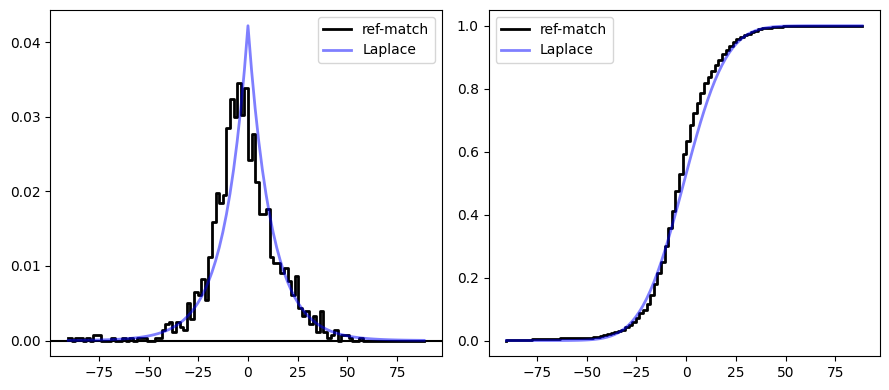

In [119]:
fig, ax = plt.subplots(1,2, figsize=(9,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].axhline(0, c='k')
ax[i].plot(xvals, dhist, c='k', lw=2, ds='steps', label='ref-match', zorder=1)
#ax[i].plot(xvals, mhist, c='green', lw=2, ds='steps', label='means', alpha=0.5, zorder = 2)
#ax[i].plot(xvals, normal, c='red', lw=2, label='Normal', alpha=0.5 , zorder = 3)
ax[i].plot(xvals, laplace, c='blue', lw=2, label='Laplace', alpha=0.5, zorder = 4 )

i+=1
ax[i].plot(xvals, dcdf, c='k', label='ref-match', ds='steps', lw=2, alpha=1, zorder=1)
#ax[i].plot(xvals, dcdf, c='green', label='means', ds='steps', lw=2, alpha=1, zorder=2)
#ax[i].plot(xvals, lcdf, c='r', label='Normal', ds='steps', lw=2, alpha=0.5, zorder=3)
ax[i].plot(xvals, ncdf, c='b', label='Laplace', lw=2, alpha=0.5, zorder=4)

for i in range(len(ax)):
    ax[i].legend();

fig.tight_layout()

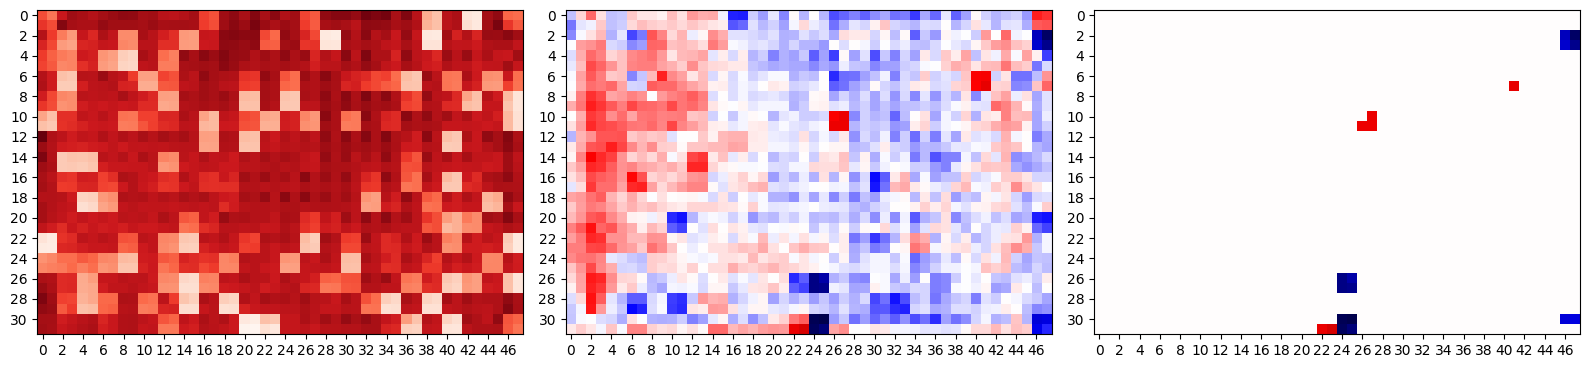

In [131]:
# FIND OUTLIERS BY SOME CRITERIA

# 1. Assume differences follow a Laplace distrubution. Outliers will be those outside the 1-alpha interval

#alpha = 0.01
#threshold = np.abs(b * np.log(2*alpha))
#tmask = np.abs(diff) > threshold

# 2. Outliers are those 3 stds away from the mean
threshold = 3*np.std(diff)
tmask = np.abs(diff) > threshold

# 3. Outliers will be those outside far away from the IQR, like when making boxplots
#q1,q3 = np.quantile(diff, [0.2,0.8]); iqr = q1 - q3
#tmask = (diff < q1 - 1.5*iqr) | (diff > q3 + 1.5*iqr)

fig, ax = plt.subplots(1,3, figsize=(16,5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(reference, cmap='Reds_r')
ax[1].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[2].imshow(diff*tmask, cmap='seismic', vmin=-vlim, vmax=vlim)

for i in range(len(ax)):
    ax[i].set_xticks(range(0,ncols,2), range(0,ncols,2))
    ax[i].set_yticks(range(0,nrows,2), range(0,nrows,2));
fig.tight_layout()

In [75]:
wilcoxs = np.zeros((nrows//2, ncols//2))
wilcoxp = np.zeros((nrows//2, ncols//2))

for i in range(0,nrows,2):
    for j in range(0, ncols, 2):
        foo = stats.wilcoxon(diff[i:i+2, j:j+2].ravel(), method='auto', zero_method='wilcox', alternative='two-sided')
        wilcoxs[i//2, j//2] = foo.statistic
        wilcoxp[i//2, j//2] = foo.pvalue

In [78]:
stats.wilcoxon(diff.ravel(), method='auto', zero_method='wilcox', alternative='two-sided')

WilcoxonResult(statistic=584318.5, pvalue=0.8360745714297961)

In [80]:
wilcoxs

array([[0. , 0. , 0. , 1. , 2. , 1. , 1. , 3. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [3. , 0. , 1. , 0. , 0. , 0. , 2. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 1.5, 5. , 1. , 3. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 3. , 0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 2. , 3. , 0. , 0. , 2. ,
        0. , 0. , 1. , 1. , 1. , 3. , 0. , 0. , 1. , 0. , 4. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 1. , 4. , 3. , 0. , 0. ,
        0. , 0. , 0. , 0. , 2. , 3. , 1. , 4. , 0. , 3. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 2. , 5. , 0. , 3. , 3. , 1. ,
        0. , 0. , 0. , 0. , 0. , 5. , 0. , 1. , 0. , 1. , 0. ],
       [1. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 3. , 3. , 4. ,
        1. , 0. , 3. , 0. , 0. , 1. , 3. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. 